Here, we want to know the model with the best explanatory power.

## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install python ipykernel
pip install watermark bambi xarray netcdf4 seaborn
# pip install bokeh
```

In [1]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
grid_results = pd.read_csv('data/classification_results/grid_results.csv', index_col=0)

grid_results['label'] = grid_results['param_extract__kind'] + ' (' + grid_results['param_extract__frequency_band'] + ')'

# Sift out the best params (C and feature selections) for each model
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]
grid_results.drop_duplicates(subset='label', inplace=True)

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')

grid_results = grid_results[['param_extract__frequency_band', 'param_extract__kind', 'test_score']]
grid_results.rename(columns={'param_extract__frequency_band': 'band',
                       'param_extract__kind': 'kind'},
                        inplace=True)
grid_results[['input_type', 'source']] = grid_results['kind'].apply(lambda x: x.split(' ')).apply(pd.Series)
grid_results['source'] = grid_results['source'].apply(lambda x: x.replace('source', 'region'))

grid_results['source'] = grid_results['source'].astype('category')
grid_results['input_type'] = grid_results['input_type'].astype('category')
grid_results['kind'] = grid_results['kind'].astype('category')

In [3]:
model2 = bambi.Model('test_score ~ 0 + source * kind * band', grid_results)
fitted = model2.fit(tune=100, draws=400, chains=2)

az.summary(fitted).sort_values('mean', ascending=False)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, source, kind, band, test_score_sigma]


/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 20 tune and 100 draw iterations (80 + 400 draws total) took 2090 seconds.
The acceptance probability does not match the target. It is 0.9263, but should be close to 0.8. Try to increase the number of tuning steps.
The chain re

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,23.881,12.198,10.031,50.894,5.341,4.104,6.0,13.0,1.97
test_score_sigma,4.904,0.047,4.819,4.992,0.002,0.002,396.0,279.0,1.00
band[gamma],0.690,0.201,0.335,1.072,0.014,0.010,217.0,251.0,1.02
band[beta],-0.163,0.212,-0.549,0.230,0.014,0.012,231.0,244.0,1.02
band[theta],-0.336,0.197,-0.721,0.019,0.013,0.010,241.0,249.0,1.04
kind[power sensor],-1.172,0.236,-1.543,-0.628,0.024,0.017,116.0,242.0,1.04
band[delta],-2.329,0.195,-2.636,-1.879,0.012,0.008,275.0,259.0,1.02
kind[plv source],-2.876,12.198,-29.823,11.079,5.338,4.089,6.0,13.0,1.98
kind[plv sensor],-3.038,0.209,-3.443,-2.684,0.018,0.013,142.0,264.0,1.04
source[sensor],-3.103,12.196,-29.903,10.911,5.344,4.097,6.0,13.0,1.99


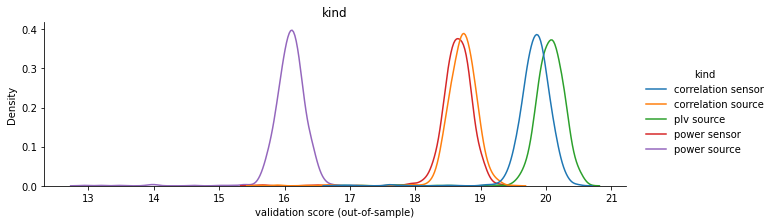

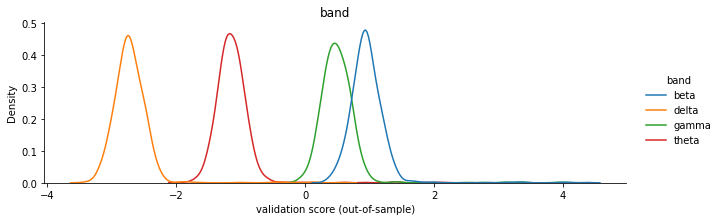

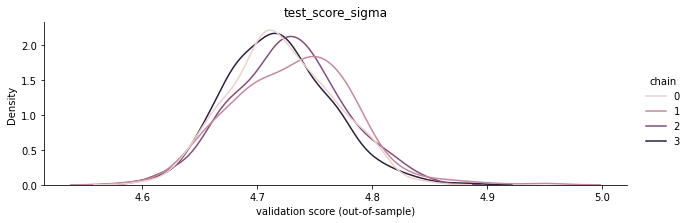

In [5]:
import seaborn as sns

for i, var_name in enumerate(fitted['posterior'].data_vars):
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name else 2
    g = sns.displot(data=plot_data,
                    x=var_name,
                    kind='kde',
                    aspect=3,
                    height=3,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    # height=2, aspect=2,
                    )
    g.set(xlabel='validation score (out-of-sample)')
    g.set(title=var_name)
    g.legend.set_title(g.legend.get_title().get_text().replace('_dim',''))

    plt.show()


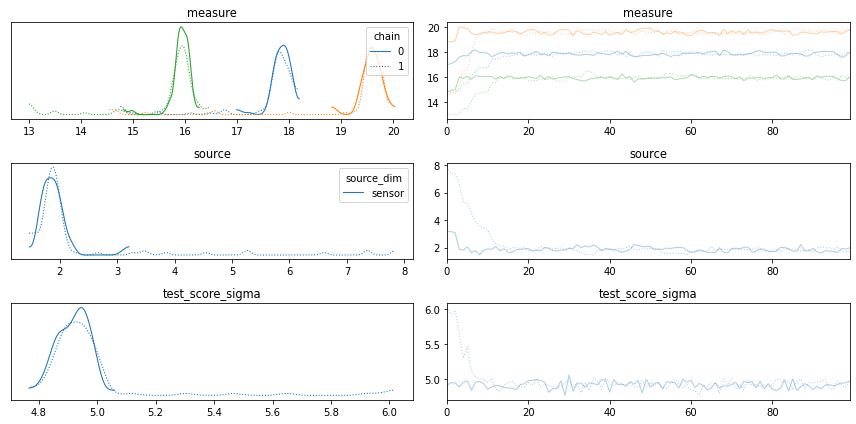

In [10]:
az.plot_trace(fitted, legend=True)

plt.tight_layout()
plt.show()

In [ ]:
# Model structure